# Covid-19 Data Analysis March 26th

The novel coronavirus is bringing societies worldwide to a halt and causing widespread health impacts. Still, there appears to be a paucity of information how the crisis is likely to unfold in the near future. Most news outlets only show aggreate numbers, color-coded world maps, or descriptive statistics of the current situation. 

This workbook is part of a [daily series](https://mlnoga.github.io/covid19-analysis/), in which I am taking a closer look at numbers and trends, and making some tentative projections. All data are taken from the Johns Hopkins Covid-19 [dataset](https://github.com/CSSEGISandData/COVID-19) on GitHub. Each day, Johns Hopkins update the dataset with figures for the previous day. Numbers are pulled live when running the workbook. 

All projections are based on curve fitting on a per-country level. Thus, they extrapolate current trends. By nature, they can neither reflect the impact of recently enacted measures, which are expected to reduce infection rates, nor can they reflect new adverse developments. So please take everything with a grain of salt.

Please stay safe, look after your loved ones, and stay healthy. 

In [2]:
# Hide raw notebook code in exported HTML
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show) {
   $('div.input').hide();
 } else {
   $('div.input').show();
 }
 code_show = !code_show
} 
$(document).ready(code_toggle);
</script>
<form"><input type="button" value="Show/hide code" onclick="code_toggle()"></input></form>

<!-- Global site tag (gtag.js) - Google Analytics -->
<script async src="https://www.googletagmanager.com/gtag/js?id=UA-161715363-1"></script>
<script>
  window.dataLayer = window.dataLayer || [];
  function gtag(){dataLayer.push(arguments);}
  gtag('js', new Date());

  gtag('config', 'UA-161715363-1');
</script>
''')

## Global Overview

As of March 25th end of day, there were 468k confirmed cases of Covid-19 globally, and this figure continues to grow at 12% per day, after a temporary dip yesterday. Fluctuations in the 10-12% range seem normal in the past few days. 

21k people have died from this illness. At 13.7% per day, daily growth in deaths is slightly up from yesterday. 4.5% of confirmed cases have died to date.

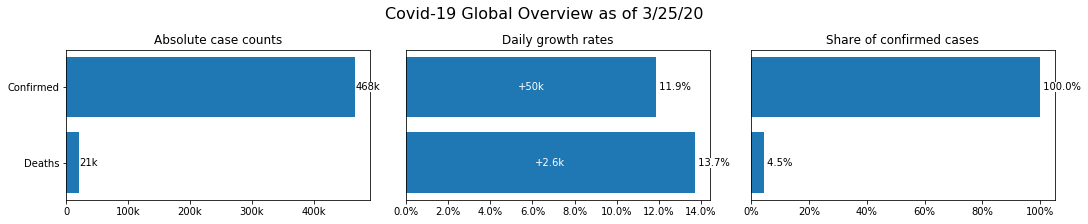

In [3]:
# Import required libraries
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import numpy  as np
from scipy.optimize import curve_fit
from scipy.optimize import OptimizeWarning
from scipy.special import expit

import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as mdates

import datetime as datetime
import operator
import sys
import warnings
import math

# Load data and group by country/region
def loadAndGroup(fileName, groupBy="Country/Region"):
    df=pd.read_csv(fileName)
    df=df.groupby(groupBy).sum()
    return df
    
# Load data
confd =loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
#recovd=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
deaths=loadAndGroup('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
population=loadAndGroup('./population.csv','Country')
today =confd.columns[-1]

# Calculate new, previous and total as well as growth rate from time series
def newPrevTotalGrowth(df):
    df1        =df.loc[:, df.columns[-2]:]
    prev, total=df1.sum(axis=0)
    delta      =total-prev
    return delta, prev, total, delta/prev if prev!=0 else 0

# Calculate overall data sets for overview plots
confdNew,  confdPrev,  confdTotal,  confdGrowth =newPrevTotalGrowth(confd)
#recovdNew, recovdPrev, recovdTotal, recovdGrowth=newPrevTotalGrowth(recovd)
deathsNew, deathsPrev, deathsTotal, deathsGrowth=newPrevTotalGrowth(deaths)

#closedNew, closedPrev, closedTotal=recovdNew+deathsNew, recovdPrev+deathsPrev, recovdTotal+deathsTotal
#closedGrowth=closedNew/closedPrev if closedPrev!=0 else 0
#activeNew, activePrev, activeTotal=confdNew-closedNew, confdPrev-closedPrev, confdTotal-closedTotal
#activeGrowth=activeNew/activePrev if activePrev!=0 else 0

labels=['Confirmed', 'Deaths']
valuesTotal=[confdTotal, deathsTotal]
valuesNew=[confdNew, deathsNew]
valuesPrev=[confdPrev, deathsPrev]
valuesPerc=[1, deathsTotal/confdTotal]
valuesGrowth=[confdGrowth, deathsGrowth]

#labels=['Confirmed', 'Active', 'Closed', 'Recovered', 'Deaths']
#valuesTotal=[confdTotal, activeTotal, closedTotal, recovdTotal, deathsTotal]
#valuesNew=[confdNew, activeNew, closedNew, recovdNew, deathsNew]
#valuesPrev=[confdPrev, activePrev, closedPrev, recovdPrev, deathsPrev]
#valuesPerc=[1, activeTotal/confdTotal, closedTotal/confdTotal, recovdTotal/confdTotal, deathsTotal/confdTotal]
#valuesGrowth=[confdGrowth, activeGrowth, closedGrowth, recovdGrowth, deathsGrowth]

# Prepare overview plot
plt.rcParams['figure.figsize'] = [15, 3]
fig, ax=plt.subplots(nrows=1, ncols=3, constrained_layout=True)
fig.suptitle('Covid-19 Global Overview as of %s' % today, fontsize="16")

# Human readable formatting for figures ranging in single digits, thousands, millions and billions
def humanReadable(x):
    if math.isnan(x):
        return "NaN"
    if x<0:
        return "-"+humanReadable(-x)
    formats=[ (10000000000, 1000000000,"%.0fb"), (1000000000,1000000000, "%.1fb"), (10000000, 1000000, "%.0fm"), 
             (1000000, 1000000, "%.1fm"), (10000,1000,"%.0fk"), (1000,1000,"%.1fk") ]
    for threshold, divider, formatString in formats:
        if x>=threshold:
            return formatString % (x/divider)
    return "%d" % x

@plticker.FuncFormatter
def hrFormatter(x, pos):
    return humanReadable(x)

# Left side: case counts
ax[0].set_title('Absolute case counts')
#ax[0].get_yaxis().set_visible(False)
#ax2 = ax[0].twinx()
ax[0].invert_yaxis()
#ax2.invert_xaxis()
ax[0].xaxis.set_major_formatter(hrFormatter)
ax[0].barh(labels, valuesTotal)
for i, v in enumerate(valuesTotal):
    ax[0].text(v, i, humanReadable(v), ha='left', va='center', color='k', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')

# Middle: Growth rates
ax[1].set_title('Daily growth rates')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].barh(labels, valuesGrowth)
for i, v in enumerate(zip(valuesGrowth, valuesNew)):
    ax[1].text(v[0]/2, i, "+"+humanReadable(v[1]), ha='center', va='center', color='w')
for i, v in enumerate(valuesGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')
    
# Right: Percentages
ax[2].set_title('Share of confirmed cases')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[2].barh(labels, valuesPerc)
for i, v in enumerate(valuesPerc):
    ax[2].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'), backgroundcolor='w')
        


## Global Time Series

On a global level, exponential growth appears to continue unabated. The first exponential growth wave in China plateaued in mid-February. Since then, the global spread of the disease has launched a second exponential growth wave of significantly higher magnitude. 

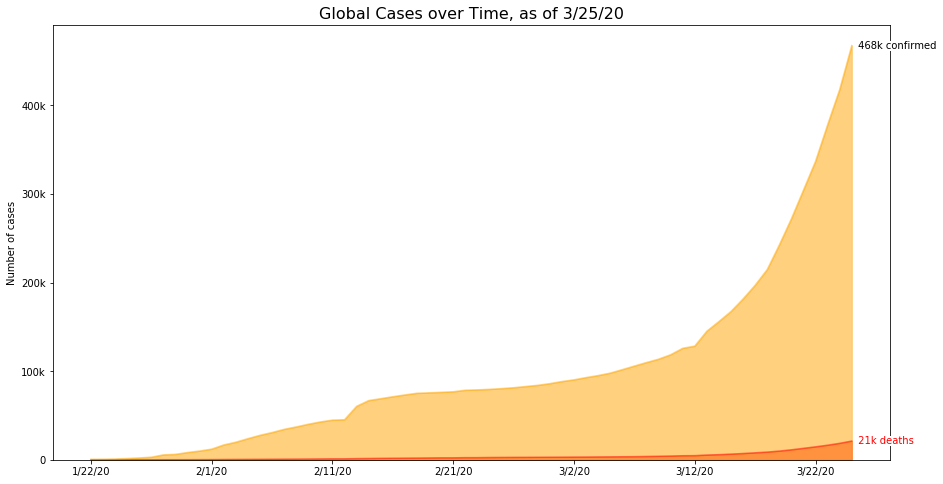

In [4]:
# Aggregate time series data on global level
globalConfd=confd.loc[:, confd.columns[2]:].sum(axis=0)
#globalRecovd=recovd.loc[:, confd.columns[2]:].sum(axis=0)
globalDeaths=deaths.loc[:, confd.columns[2]:].sum(axis=0)
#globalClosed=globalRecovd+globalDeaths
#globalActive=globalConfd-globalClosed
globalDF=pd.DataFrame({
    'Deaths':globalDeaths, 
#    'Active':globalActive,
#    'Recovered':globalRecovd,
    'Confirmed':globalConfd
})

# Prepare stacked area plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
#colors=['r', 'orange', 'g']
colors=['r', 'orange']
globalDF.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Global Cases over Time, as of %s" % today, fontsize=16)
ax.set_ylabel("Number of cases")
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
#c, r, d, a, cl=globalConfd[x], globalRecovd[x], globalDeaths[x], globalActive[x], globalClosed[x]
c, d=globalConfd[x], globalDeaths[x]
ax.text(xPos+0.25, d, " %s deaths" %  humanReadable(d), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#ax.text(xPos, d+a/2, " %s active" %  humanReadable(a), ha='left', va='center', c='orange')
#ax.text(xPos, d+a+r/2, " %s recovered" %  humanReadable(r), ha='left', va='center', c='g')
ax.text(xPos+00.25, c, " %s confirmed" % humanReadable(c), ha='left', va='center', c='k', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()


Absolute daily case growth continues to expand, although daily fluctuations in rate are apparent.

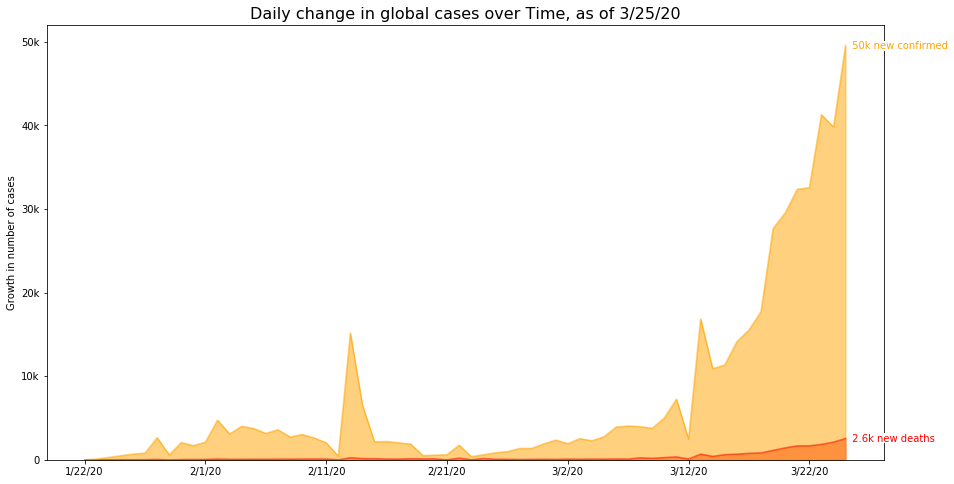

In [5]:
# Calculate daily deltas
globalConfdDelta=globalConfd.diff()
#globalRecovdDelta=-globalRecovd.diff()
globalDeathsDelta=globalDeaths.diff()
globalDFDelta=pd.DataFrame({
    'DeathsDelta':globalDeathsDelta, 
#    'RecoveredDelta':globalRecovdDelta,
    'ConfirmedDelta':globalConfdDelta
})

# Prepare stacked area plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
#colors=['r', 'g', 'orange' ]
colors=['r', 'orange' ]
globalDFDelta.plot(ax=ax, kind='area', stacked=False, color=colors)
ax.set_title("Daily change in global cases over Time, as of %s" % today, fontsize=16)
ax.set_ylabel("Growth in number of cases")
ax.yaxis.set_major_formatter(hrFormatter)
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
#c, r, d=globalConfdDelta[x], globalRecovdDelta[x], globalDeathsDelta[x]
c, d=globalConfdDelta[x], globalDeathsDelta[x]
ax.text(xPos+0.25, d, " %s new deaths" % humanReadable(d), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#ax.text(xPos, r+d, " %s new recovered" % humanReadable(r), ha='left', va='center', c='g')
ax.text(xPos+0.25, c, " %s new confirmed" % humanReadable(c), ha='left', va='center', c='orange', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

Percentage growth figures remain in the 10-12% range for new cases, and for deaths in the 12-14% range globally.

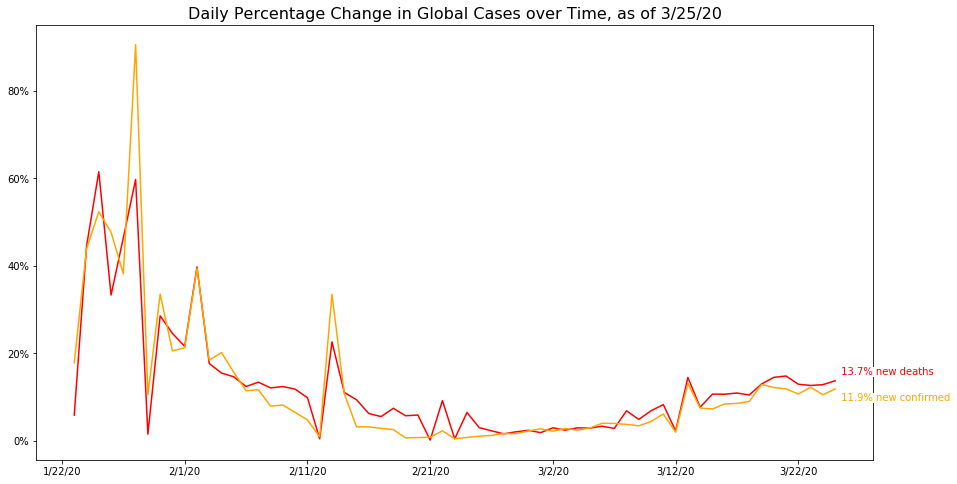

In [6]:
# Calculate daily deltas
globalConfdDeltaPerc=globalConfdDelta/globalConfd.shift(periods=1)
#globalRecovdDeltaPerc=-globalRecovdDelta/globalRecovd.shift(periods=1)
globalDeathsDeltaPerc=globalDeathsDelta/globalDeaths.shift(periods=1)
globalDFDeltaPerc=pd.DataFrame({
    'DeathsDeltaPerc':globalDeathsDeltaPerc, 
#    'RecoveredDeltaPerc':globalRecovdDeltaPerc,
    'ConfirmedDeltaPerc':globalConfdDeltaPerc
})

# Prepare stacked area plot
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(1, 1, 1)
#colors=['r', 'g', 'orange' ]
colors=['r', 'orange' ]
globalDFDeltaPerc.plot(ax=ax, kind='line', stacked=False, color=colors)
ax.set_title("Daily Percentage Change in Global Cases over Time, as of %s" % today, fontsize=16)
ax.yaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax.get_legend().remove()

# Plot and label the values
xPos=len(globalConfd.index)-1
x=globalConfd.index[xPos]
#c, r, d=globalConfdDeltaPerc[x], globalRecovdDeltaPerc[x], globalDeathsDeltaPerc[x]
c, d=globalConfdDeltaPerc[x], globalDeathsDeltaPerc[x]
ax.text(xPos+0.25, d+0.02, " %.1f%% new deaths" % (d*100), ha='left', va='center', c='r', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
#ax.text(xPos, r, " %.1f%% new recovered" % (r*100), ha='left', va='center', c='g')
ax.text(xPos+0.25, c-0.02, " %.1f%% new confirmed" % (c*100), ha='left', va='center', c='orange', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
plt.show()

## Country Overview

China continues to have the most cases, however, case growth in China appears no longer material. The number of cases in Italy, the US, Spain and Germany exceeds Iran; with France set to overtake Iran within days as well. 

Among larger western countries, the US, Spain and Portugal stand out with a growth rate around 25%, respectively; the rate in Canada appears to have dropped. The growth rate in Germany remains around 13. Apparently, heavier social distancing measures including school and university closures are showing first impacts. 

In the same group, Italy and Switzerland continue to have the highest number of cases per capita, up 10 to a value of 125 cases per 100k, a proxy for the highest infection risk from social interaction. Spain has the next highest case incidence per capita, up 20 to 105 cases per 100k.

Case fatality rates (CFR), measured as number of deaths per number of confirmed cases, remain highest in Italy with 10% (slightly up), as well as Iran and Spain with 7-8%, possibly due to overwhelmed health systems. China, France, the UK, the Netherlands and Japan are in the 3.5-5.5% range. The comparatively low CFR in Germany has again crept up .1ppt to 0.6%.

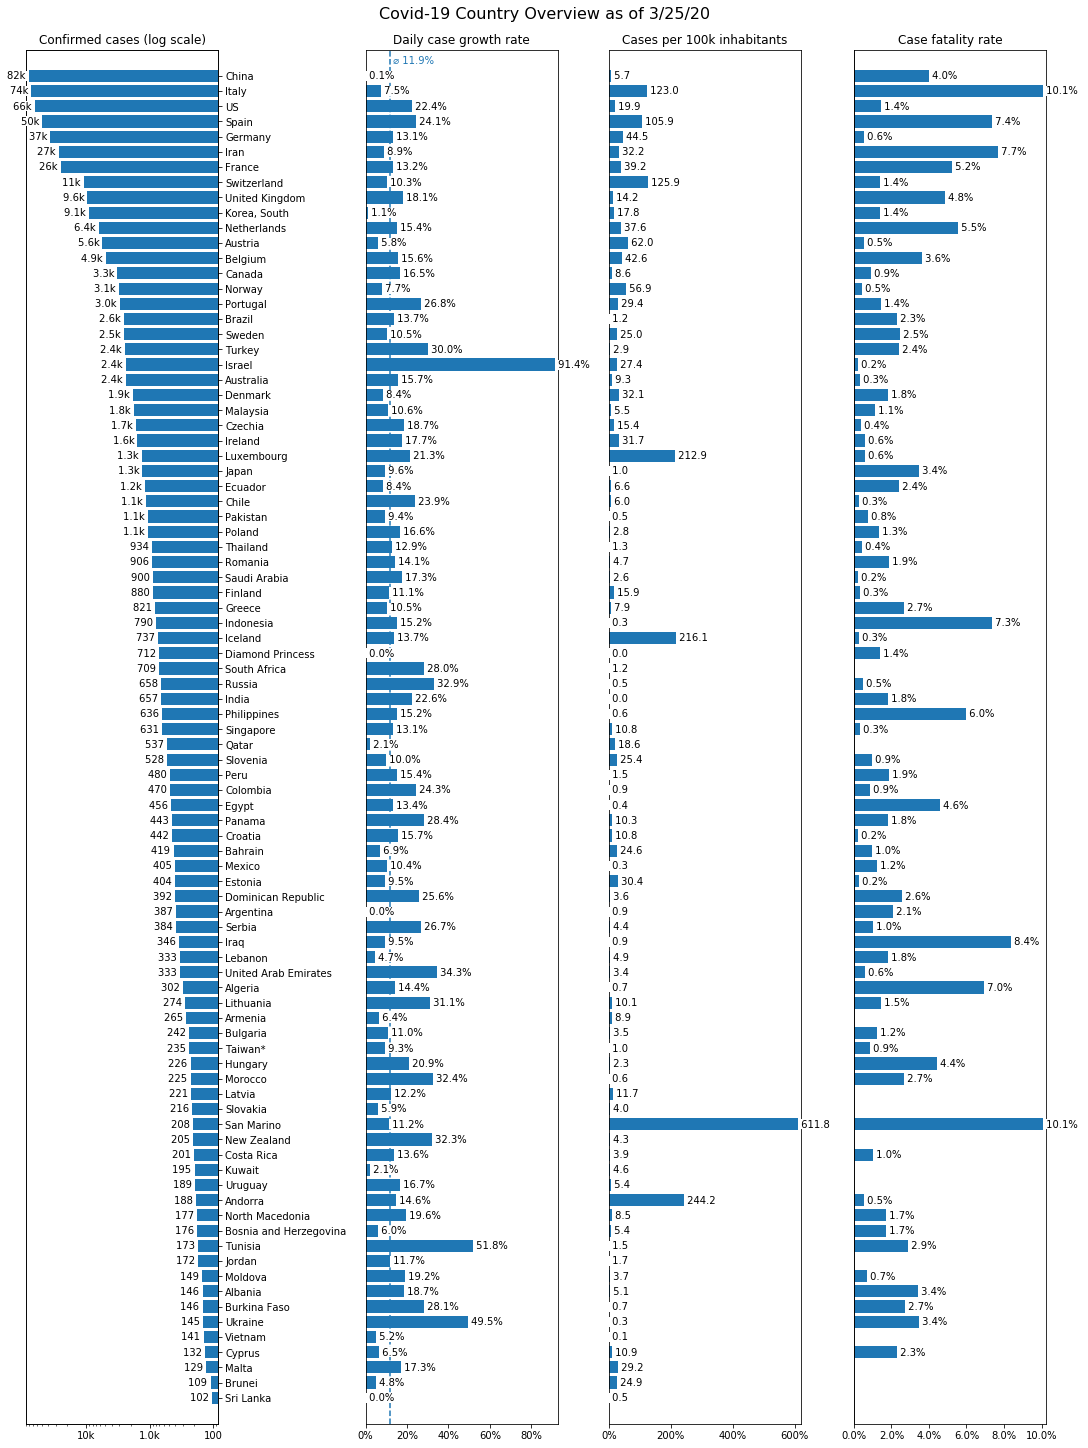

In [7]:
def lastGrowth(data):
    if len(data)>=2 and data[-2]>0:
        return data[-1]/data[-2]-1
    return 0    

# Calculate summary stats for all countries with number of cases above the threshold
threshold=100
validCountries=[]
for name in confd.index.values:
    conf1=confd.loc[name, confd.columns[2]:] # select row for given country, filter out lat/lon columns
    confv=conf1.to_numpy()
    if confv[-1]>=threshold:
        #recovd1=recovd.loc[name, confd.columns[2]:]
        #recovdv=recovd1.to_numpy()

        death1=deaths.loc[name, confd.columns[2]:]
        deathv=death1.to_numpy()

        summary={
            'Name':name,
            'Cases':confv[-1],
            'CaseGrowth':lastGrowth(confv),
            #'Recovered':recovdv[-1],
            #'RecoveredGrowth':lastGrowth(recovdv),
            'Deaths':deathv[-1],
            'DeathsGrowth':lastGrowth(deathv),
            'CFRTotal':deathv[-1]/confv[-1],
            #'CFROutcome':deathv[-1]/(deathv[-1] + recovdv[-1]) if deathv[-1]+recovdv[-1]>0 else 0,
        }
        validCountries.append(summary)

# Prepare sorted stats        
validCountries.sort(key=lambda x: x['Cases'], reverse=True)

# Prepare data for plots
countryNames=[x['Name'] for x in validCountries]
countryCases=[x['Cases'] for x in validCountries]
countryGrowth=[x['CaseGrowth'] for x in validCountries]
countryCFRTotal=[x['CFRTotal'] for x in validCountries]
#countryCFROutcome=[x['CFROutcome'] for x in validCountries]
countryPop1000=[population.loc[x]['PopulationInThousands'] for x in countryNames]
countryCasesPerPop1000=[cases/pop if pop!=0 else 0 for cases, pop in zip(countryCases, countryPop1000)]

# Prepare overview plot
plt.rcParams['figure.figsize'] = [15, 20]
fig, ax=plt.subplots(nrows=1, ncols=4, constrained_layout=True)
fig.suptitle('Covid-19 Country Overview as of %s' % today, fontsize="16")

# Left hand side: Plot lastest confirmed cases by country
ax[0].set_xscale('log')
ax[0].set_title('Confirmed cases (log scale)')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames, countryCases)
for i, v in enumerate(countryCases):
    ax2.text(v, i, "%s " % humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle left: Plot latest growth rate by country
ax[1].set_title('Daily case growth rate')
ax[1].invert_yaxis()
ax[1].get_yaxis().set_visible(False)
ax[1].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[1].margins(0.015)
ax[1].barh(countryNames, countryGrowth)
for i, v in enumerate(countryGrowth):
    ax[1].text(v, i, " %.1f%%" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Middle right: Plot cases per 1000 population
ax[2].set_title('Cases per 100k inhabitants')
ax[2].invert_yaxis()
ax[2].get_yaxis().set_visible(False)
ax[2].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[2].margins(0.015)
ax[2].barh(countryNames, countryCasesPerPop1000)
for i, v in enumerate(countryCasesPerPop1000):
    ax[2].text(v, i, " %.1f" % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

line =ax[1].axvline(x=confdGrowth, ymin=0, ymax=len(countryNames), ls="--")
ax[1].text(confdGrowth, -1, " \u2300 %.1f%%" % (confdGrowth*100), ha='left', va='center', color=line.get_color())

# Right: Plot CFR by country
ax[3].set_title('Case fatality rate')
ax[3].invert_yaxis()
ax[3].get_yaxis().set_visible(False)
ax[3].xaxis.set_major_formatter(plticker.PercentFormatter(1.0))
ax[3].axvline(x=0, ymin=0, ymax=len(countryNames), color='k', ls='-', lw='.8')
ax[3].margins(0.015)
ax[3].barh(countryNames, countryCFRTotal)
for i, v in enumerate(countryCFRTotal):
    if v!=0:
        ax[3].text(v, i, " %.1f%% " % (v*100), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

plt.show()

Case fatality rate (CFR) is calculated as deaths/total confirmed cases. This is likely to be an understatement of the true value, as the outcome of currently active cases is still open. Alternative CFR measures like deaths/(deaths+recovered) lead to outlier results for many countries, as  recovery appears to take longer and data capture about recovery tends to be less strict than about deaths. As Johns Hopkins has stopped updating recovery time series, providing that indicator is no longer possible.

## Growth of Confirmed Cases

The chart shows the growth of confirmed cases by country. To developments more comparable across countries, each country curve is shifted in time so that day 0 corresponds to the moment when that country exceeds a threshold number of confirmed cases (here=100). 

From reported numbers, containment and mitigation appear to be most effective in China, South Korea, Singapore and Japan. Iran's flattening looks a bit doubtful again; while Norway and Sweden still appear to be growing less rapidly. Most major western countries still continue to follow the frightening trajectory of Italy.

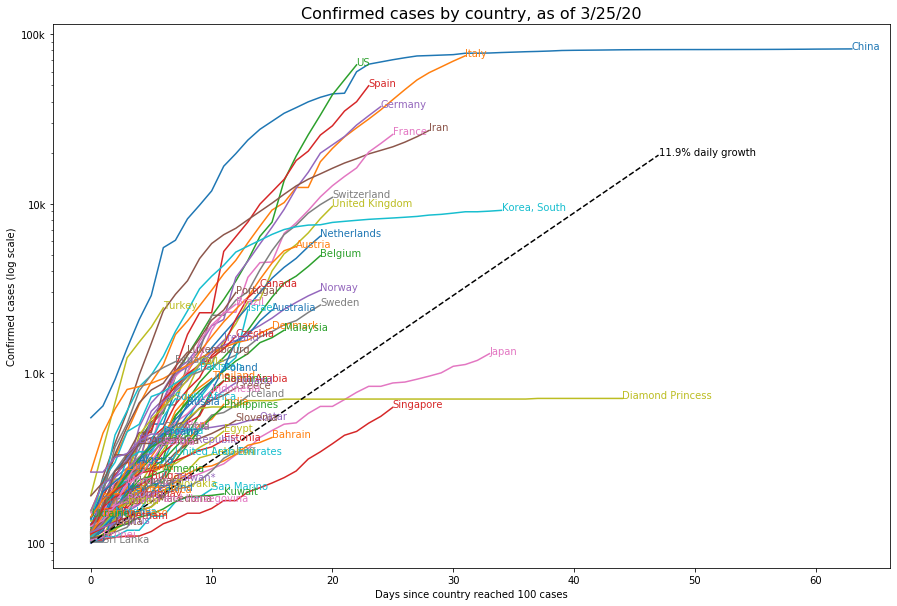

In [8]:
# Retrieve data for one country from the data frame
def getData(df, name):
    df1   =df.loc[name, df.columns[2]:]
    days  =df1.index.values
    days  =[datetime.datetime.strptime(d,"%m/%d/%y").date() for d in days]
    daynr =range(1, len(days)+1)
    values=df1.to_numpy()
    return days, daynr, values

# Crop away starting values < n from the arrays
def startAtN(values, n):
    while(len(values)>0 and values[0]<n):
        values=values[1:]
    return values

# Plot an exponential growth line with given start value and factor
def plotFactor(ax, start,factor,length):
    xs=range(0, length)
    ys=[start]
    while(len(ys)<length):
        ys.append(factor*ys[-1])

    line, =ax.plot(xs, ys,"--k")
    c=line.get_color()
    ax.text(xs[-1], ys[-1], "%.1f%% daily growth" % (factor*100-100), color=c)

# Plot time-shifted data per country, setting y=0 where the country data set crosses the threshold
def plotTimeShiftedCountries(df, refDf, validCountries, threshold, growth, yscale, label, xlabel, ylabel, yformatter):
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(1, 1, 1)

    ax.set_title(label, fontsize=16)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale(yscale)
    ax.yaxis.set_major_formatter(yformatter)

    # Plot individual country curves
    maxLen=0
    for i, cty in enumerate(validCountries, start=0):
        name=cty['Name']
        days, daynr, values=getData(df, name)
        if (refDf is None):
            shiftedValues=startAtN(values, threshold)
        else:
            refDays, refDaynr, refValues=getData(refDf, name)
            shiftedRefValues=startAtN(refValues, threshold)
            shiftedValues=values[-len(shiftedRefValues):] if len(shiftedRefValues)>0 else []
        if(len(shiftedValues)>0):
            if(len(shiftedValues)>maxLen):
                maxLen=len(shiftedValues)
            line, =ax.plot(range(0, len(shiftedValues)), shiftedValues)
            c=line.get_color()
            ax.text(len(shiftedValues)-1, shiftedValues[-1], name, color=c)
    
    # Plot the average growth line
    if growth!=0:
        plotFactor(ax,threshold, 1+growth, 3*maxLen//4)
   
    plt.show()

threshold=100
plotTimeShiftedCountries(confd, None, validCountries, threshold, confdGrowth, 'log', 
                         "Confirmed cases by country, as of %s" % today,
                         "Days since country reached %s cases" % humanReadable(threshold),
                         "Confirmed cases (log scale)", hrFormatter)


The picture for time-shifted deaths is similar:

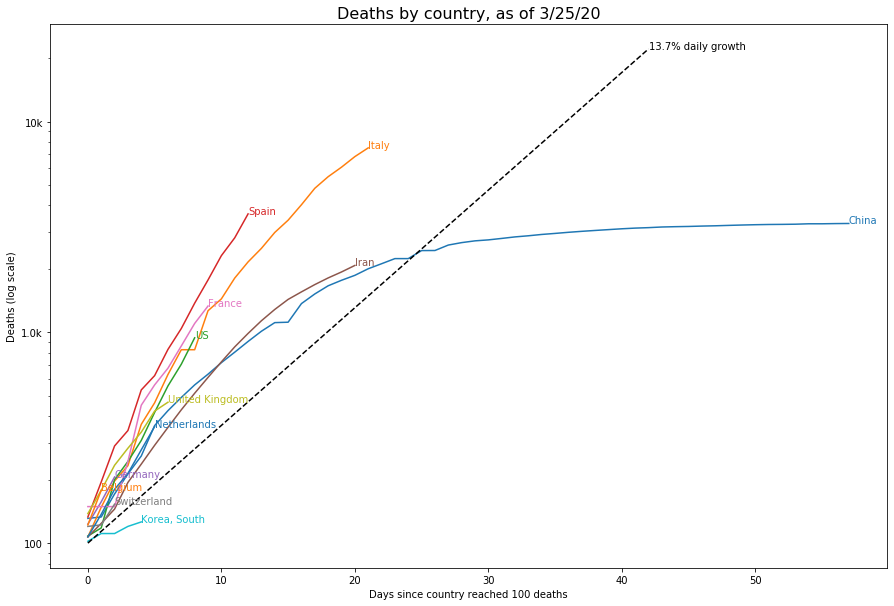

In [9]:
plotTimeShiftedCountries(deaths, None, validCountries, threshold, deathsGrowth, 'log', 
                         "Deaths by country, as of %s" % today,
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         "Deaths (log scale)", hrFormatter)

Here are the time-shifted CFRs, with curves shifted to the moment a country has accumulated 100 dead. So far, Germany, Switzerland, South Korea and the US appear to display markedly lower CFRs than the bulk of the western countries.

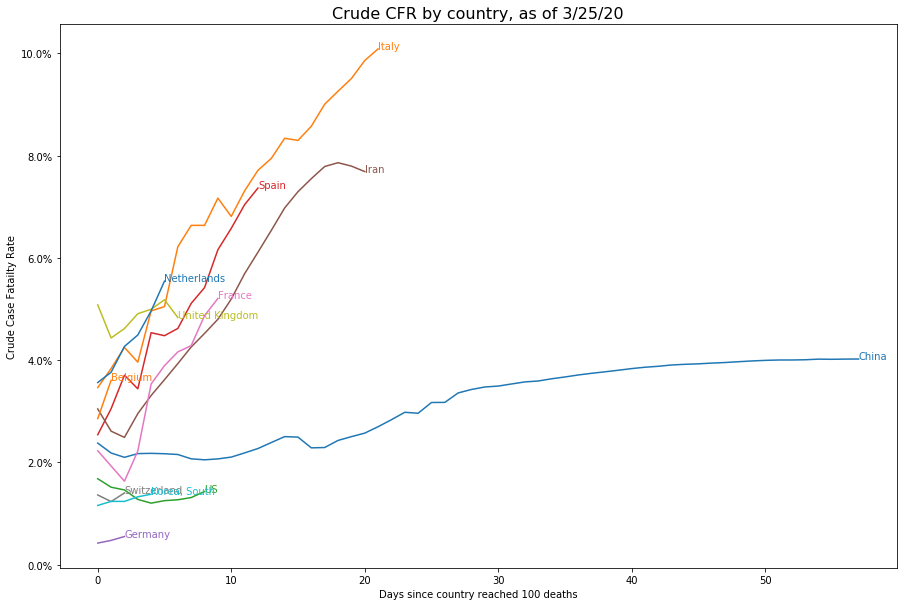

In [10]:
plotTimeShiftedCountries(deaths/confd, deaths, validCountries, threshold, 0, 'linear', 
                         "Crude CFR by country, as of %s" % today,
                         "Days since country reached %s deaths" % humanReadable(threshold),
                         "Crude Case Fatailty Rate", plticker.PercentFormatter(1.0))

## Projection of Most Impacted Countries

To project current trends, we try and fit both an exponential function, which grows without bound, and a sigmoid function, which flattens out again. We then select the curve with the lowest mean square error. Such projections should be taken with a grain of salt. The difference between exponential and sigmoid growth can be substantial over a few week's time. So slight differences in measurement noise may lead to significantly different outcomes. 

Given large day-to-day swings in projections further than a week out, I am restricting predictions to a single week for now. I have added two sigma confidence ranges to reflect the uncertainty. 

If ongoing mitigations do not materially change the course of the disease, one week from now, Italy, Spain, Germany and the US would significantly overtake China in terms of confirmed cases. 

Fingers crossed that social distancing is going to further reduce infection rates strongly.

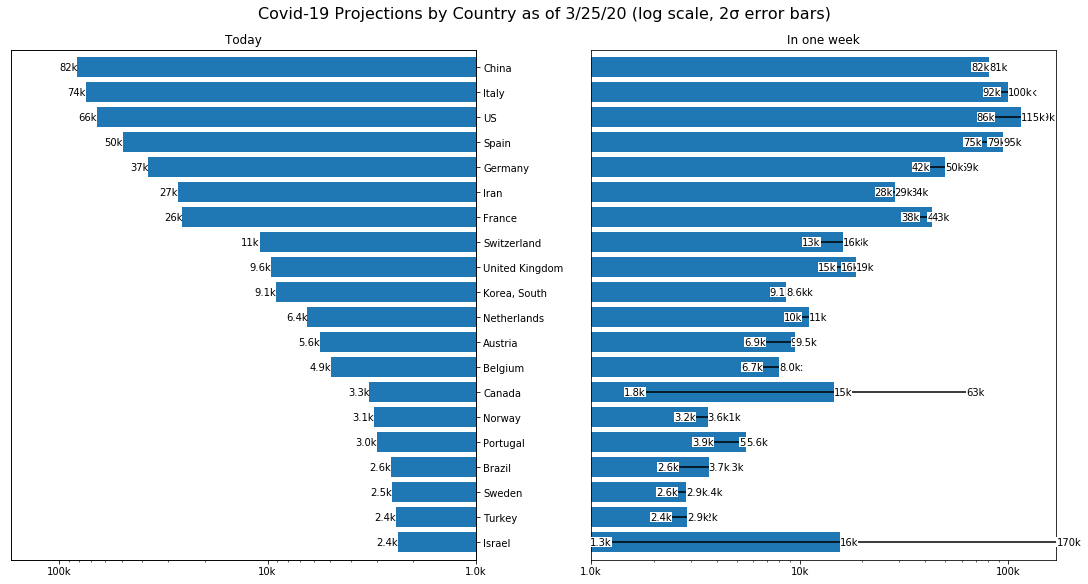

In [27]:
# Exponential model for fitting
def fitExp(t, a, b):
    return a*np.exp(b*t)

# Derivative of the exponential model (via chain rule). For more realistic projections
def fitExpDerivative(t, a, b):
    return b*fitExp(t, a, b)

# Generate a label for the exponential model
def fitExpLabeller(popt):
    return "f(x)=%g e^(%g x)" % (s3(popt[0]), s3(popt[1]))

# Sigmoid model for fitting
def fitSig(t, a, b, c):
    return a/(1.0+np.exp(-b*t - c)) 

# Derivative of the sigmoid model (via chain rule). For more realistic projections
def fitSigDerivative(t, a, b, c):
    sig=fitSig(t, 1.0, b, c)
    return a*b*sig*(1-sig)

# Generate a label for the sigmoid model
def fitSigLabeller(popt):
    return "f(x)=%g /(1- e^(\n%+g x %+g)))" % (s3(popt[0]), s3(-popt[1]), s3(-popt[2]))

# Calculate projection starting from known data via derivative
def fitSigViaDerivative(extDaynr, knownData, fitFunc, popt):
    if fitFunc==fitExp:
        fitFuncDerivative=fitExpDerivative
    else:
        fitFuncDerivative=fitSigDerivative
        
    res=[None]*len(extDaynr)
    for i in range(len(knownData)):
        res[i]=knownData[i]
    for i in range(len(knownData), len(extDaynr)):
        res[i]=(res[i-1]+0.5*(fitFuncDerivative(extDaynr[i-1], *popt)+fitFuncDerivative(extDaynr[i], *popt)))
    return res

def s3(x):
    return np.around(x,decimals=3)

def extendTime(days, daynr, extraDays):
    for i in range(0, extraDays):
        days=np.append(days,days[-1]+datetime.timedelta(days=1))
        daynr=np.append(daynr, daynr[-1]+1)
    return days, daynr

# Fit given curve to the given data
def fitCurve(daynr, values, fitFunc, p0, eqFormatter):
    try:
        # fit curve
        popt, pcov=curve_fit(fitFunc, daynr, values, p0)
    
        # estimate error
        proj=fitFunc(daynr, *popt)   # estimate error
        sqdiff=np.sum((values-proj)**2)
        
        # generate label for chart
        equation=eqFormatter(popt) 
        if(len(proj)>=2 and proj[-2]!=0):
            growthRate=proj[-1]/proj[-2]-1
        else:
            growthRate=0
        fitLabel="%s\n%.2fx daily growth" % (equation, growthRate)
        return popt, pcov, sqdiff, fitLabel
            
    except (RuntimeError, TypeError) as e:
        return [], [], sys.float_info.max, ""


# Fit multiple functions to the curve, return the fit with the lowest square error
def fitCurves(daynr, values):        
    bestFitFunc, bestPopt, bestPcov, bestSqdiff, bestFitLabel=[], [], [], sys.float_info.max, ""

    if values[-1]>1:
        fittings=[
            [ fitExp, [0.1, 0.1],             fitExpLabeller ],
            [ fitSig, [values[-1], 0.1, -10], fitSigLabeller ]
        ]

        # Perform and evaluate curve fits
        for fitFunc, p0, eqFormatter in fittings:
            popt, pcov, sqdiff, fitLabel=fitCurve(daynr, values, fitFunc, p0, eqFormatter)
            if sqdiff<bestSqdiff:
                bestFitFunc, bestPopt, bestPcov, bestSqdiff, bestFitLabel=fitFunc, popt, pcov, sqdiff, fitLabel

    return bestFitFunc, bestPopt, bestPcov, bestSqdiff, bestFitLabel

# Silently ignore optimize warnings when curve fitting
warnings.simplefilter("ignore", OptimizeWarning)

# Fit curve for the top K valid countries 
topK=20
extDayCount=7
confdFits, deathsFits={}, {}
confdProj7, confdProj7ErrorLow, confdProj7ErrorHigh=[], [], []
np.seterr(over='ignore')
for i, cty in enumerate(validCountries[0:topK], start=0):
    name=cty['Name']

    # Fit curve and project
    days, daynr, values=getData(confd, name)
    confdFits[name]=fitCurves(daynr, values)
    fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel=confdFits[name]
    extDays, extDaynr=extendTime(days, np.array(daynr), extDayCount)
    proj=fitFunc(extDaynr, *fitPopt)
    confdProj7.append(proj[len(daynr)-1+7])

    # Calculate 2 sigma error bar low
    pcov2Sigma=[2*np.sqrt(fitPcov[i][i]) for i in range(len(fitPopt))]
    poptLow=fitPopt.copy()-pcov2Sigma
    extProjLow=fitSigViaDerivative(extDaynr, values, fitFunc, poptLow)    
    poptHigh=fitPopt.copy()+pcov2Sigma
    extProjHigh=fitSigViaDerivative(extDaynr, values, fitFunc, poptHigh)    

    if extProjLow[-1]<extProjHigh[-1]:
        confdProj7ErrorLow.append(extProjLow[-1])    
        confdProj7ErrorHigh.append(extProjHigh[-1])    
    else:
        confdProj7ErrorLow.append(extProjHigh[-1])    
        confdProj7ErrorHigh.append(extProjLow[-1])    
        
    days, daynr, values=getData(deaths, name)
    deathsFits[name]=fitCurves(daynr, values)
    
# Plot overview of projections
plt.rcParams['figure.figsize'] = [15, 8]
fig, ax=plt.subplots(nrows=1, ncols=2, constrained_layout=True)
fig.suptitle('Covid-19 Projections by Country as of %s (log scale, 2\u03C3 error bars)' % today, fontsize="16")

# Leftmost chart: Plot lastest confirmed cases by country
ax[0].set_title('Today')
ax[0].get_yaxis().set_visible(False)
ax2 = ax[0].twinx()
ax2.invert_yaxis()
ax2.invert_xaxis()
ax2.set_xscale('log')
ax2.xaxis.set_major_formatter(hrFormatter)
ax2.margins(0.015)
ax2.barh(countryNames[:topK], countryCases[:topK])
for i, v in enumerate(countryCases[:topK]):
    ax2.text(v, i, humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

# Subsequent charts: plot projections for some weeks out
for i, title, proj in [(1, "In one week", confdProj7)]: 
    ax[i].set_title(title)
    ax[i].set_xscale('log')
    ax[i].xaxis.set_major_formatter(hrFormatter)
    ax[i].invert_yaxis()
    ax[i].get_yaxis().set_visible(False)
    ax[i].margins(0.015)
    ax[i].barh(countryNames[:topK], proj, xerr=(np.array(proj)-np.array(confdProj7ErrorLow),
                                                np.array(confdProj7ErrorHigh)-np.array(proj)) )
    
    for j, v in enumerate(confdProj7ErrorLow):
        if v!=None:
            ax[i].text(v, j, humanReadable(v), ha='right', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
    for j, v in enumerate(confdProj7ErrorHigh):
        if v!=None:
            ax[i].text(v, j, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))

    # then label midpoint value
    for j, v in enumerate(proj):
        ax[i].text(v, j, humanReadable(v), ha='left', va='center', bbox=dict(boxstyle='square,pad=0', fc='w', ec='none'))
            
# Ensure all charts are drawn to the same scale
low=1000
high=max(max(proj), max(confdProj7ErrorLow), max(confdProj7ErrorHigh))
ax2.set_xlim(high,low)
_,_=ax[1].set_xlim(low, high)
        

# Country Projection Details

Three charts per country: confirmed cases, recovered cases and deaths. Black dots show the actual values from Hopkins. The smooth lines have been fitted to the data, using the same curve fits as above. The dotted lines are two standard deviation bounds to the fitted data. The usual disclaimers about curve fits apply.

I have added a confidence range of +/- two standard deviations for each fitted curve parameter to the charts to reflect the uncertainty of curve fits. For the mathematically inclined, I'm using the square root of the diagonal of the covariance matrix to estimate standard deviations for each parameter individually; I am cavalierly neglecting the other parts of the covariance matrix which capture interdepdencies between the parameters. There clearly are limits to this two sigma approach: e.g., for some countries, the two sigma lower bound of the one week projection ends up lower than the already confirmed number of cases, which is counterintuitive for a monotonically growing function. 

To address that, I have added a second projection which uses a known fact (so-called a-priori): intuitively, we can remove the error bound on the projection of the last known value, because we know the exact value. Uncertainly only applies to the rate of change of the function in future. So instead of projecting the function into the future, we project its rate of change (the so-called derivative). We then add up this rate of change over time (so-called numeric integration). These projections with a priori are shown in dashed lines, and those without in dotted lines. Intuitively, the use of the a priori narrows the final error bound by about the error bounds on the projection of the last known value. As always with projections, please take them with a grain of salt.    

The curve for Korea continues to depart from both exponential and sigmoid growth functions. Please disregard for now; happy to have your suggestions for a better family of functions to fit. 

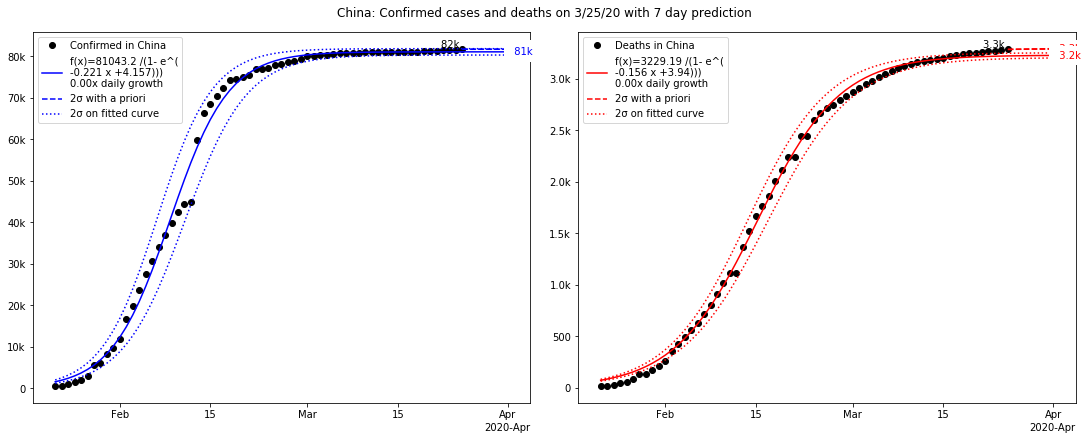

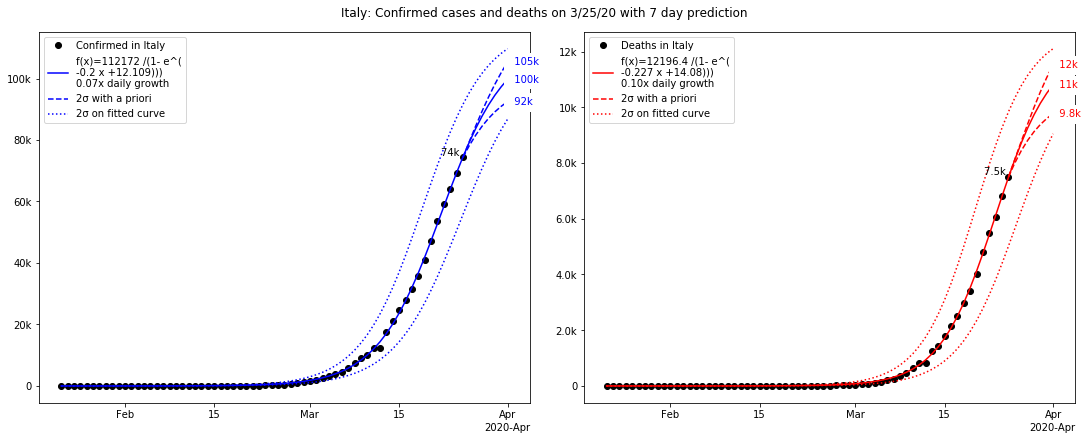

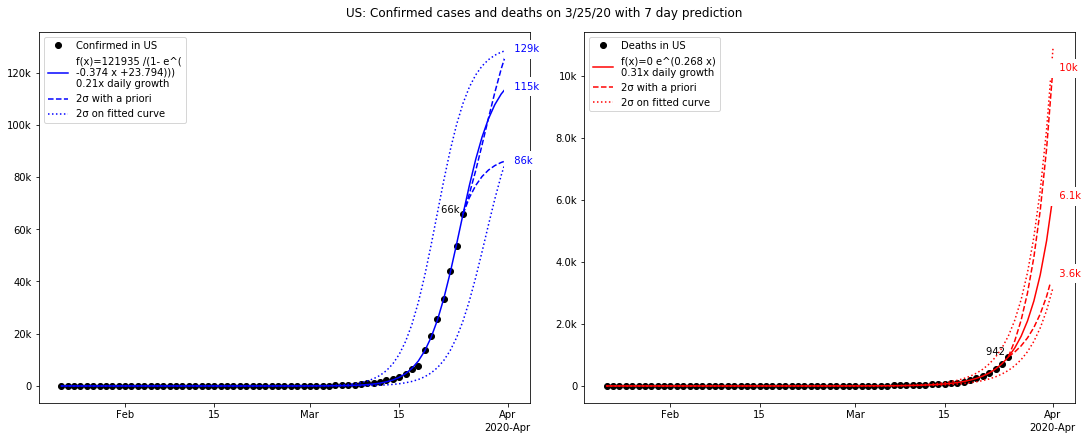

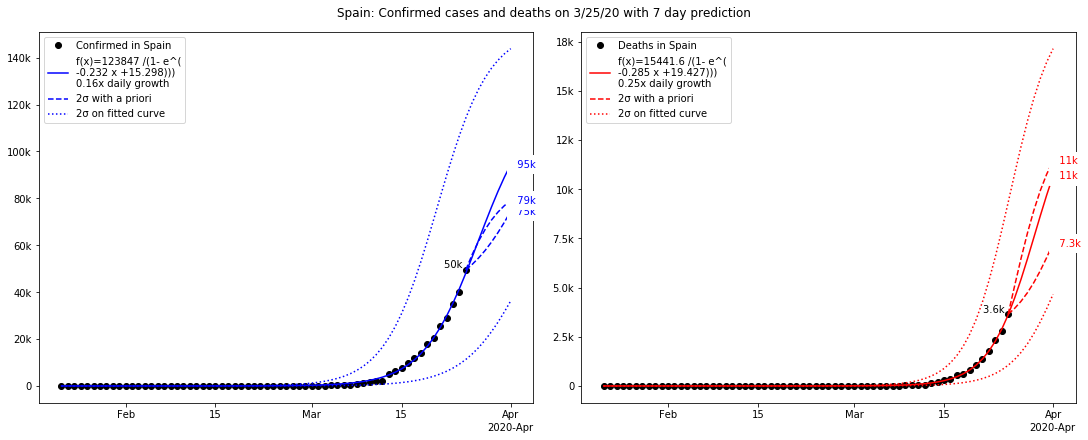

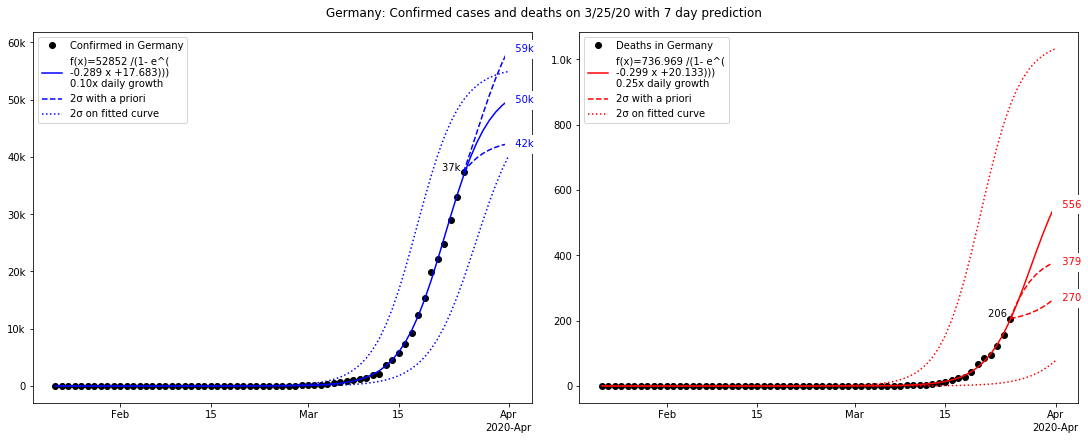

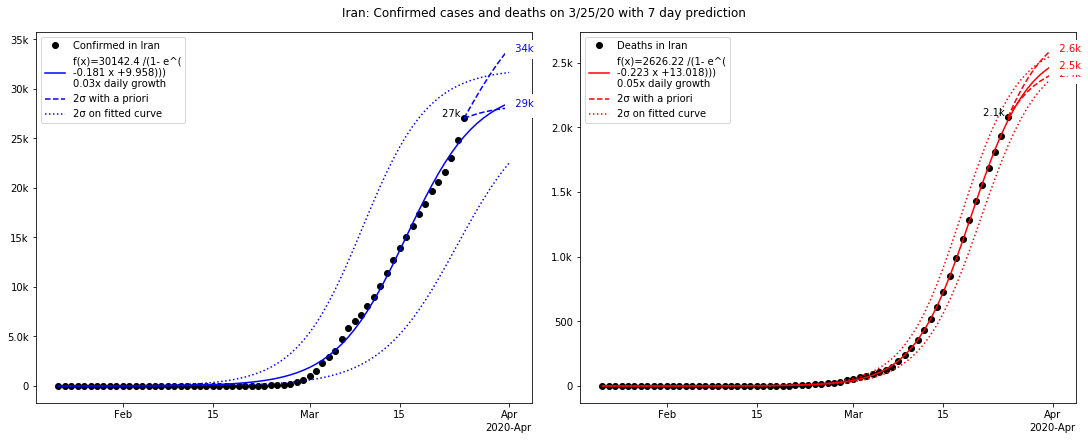

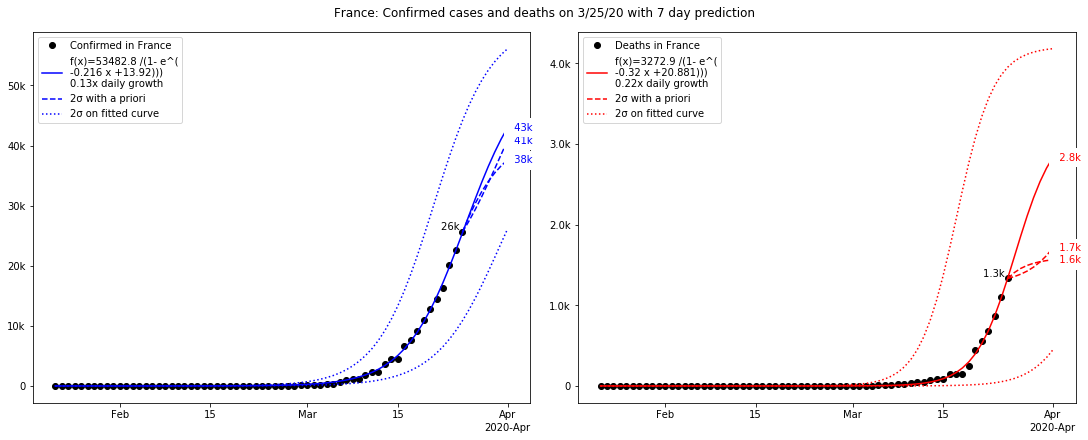

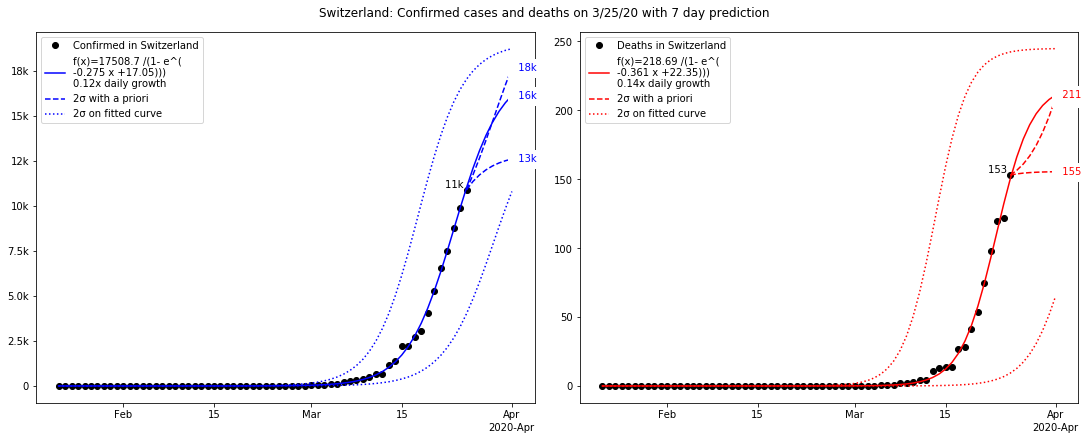

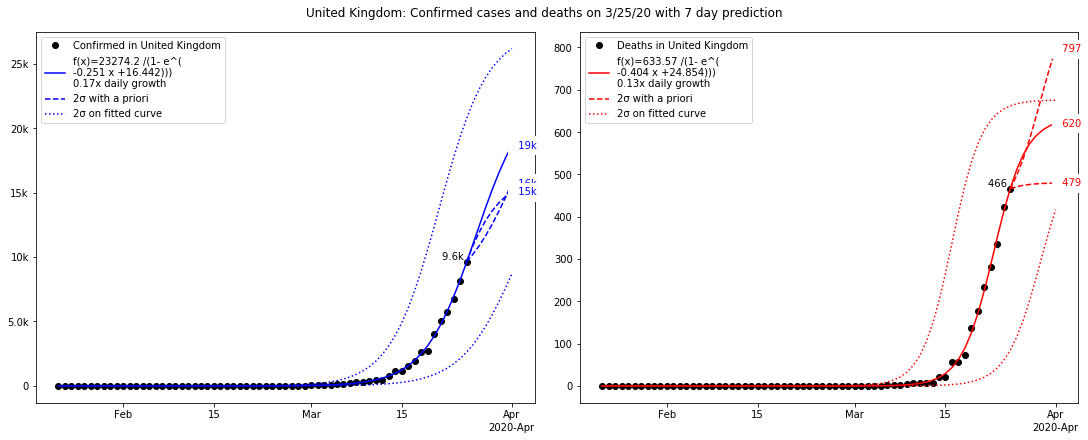

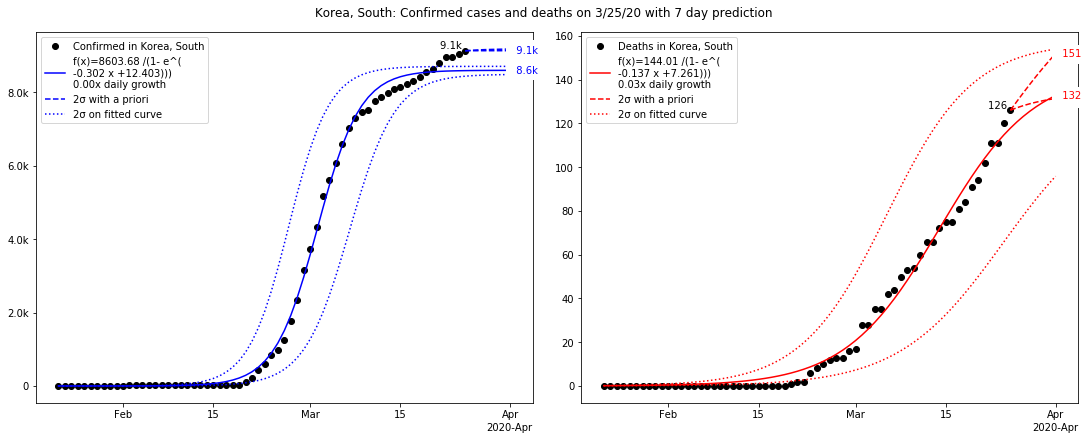

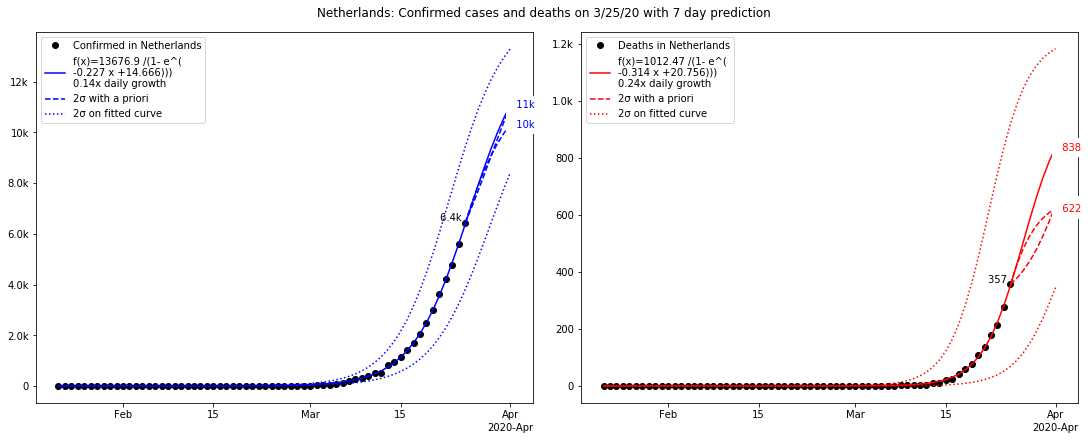

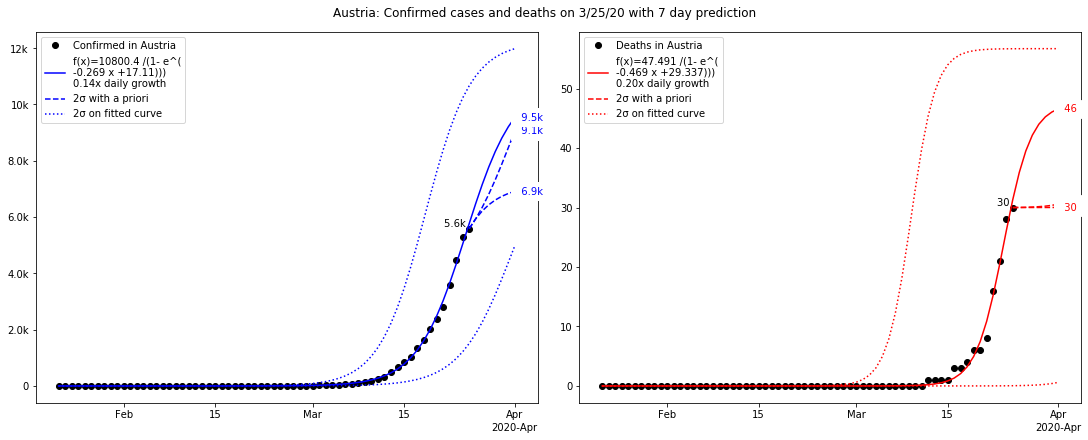

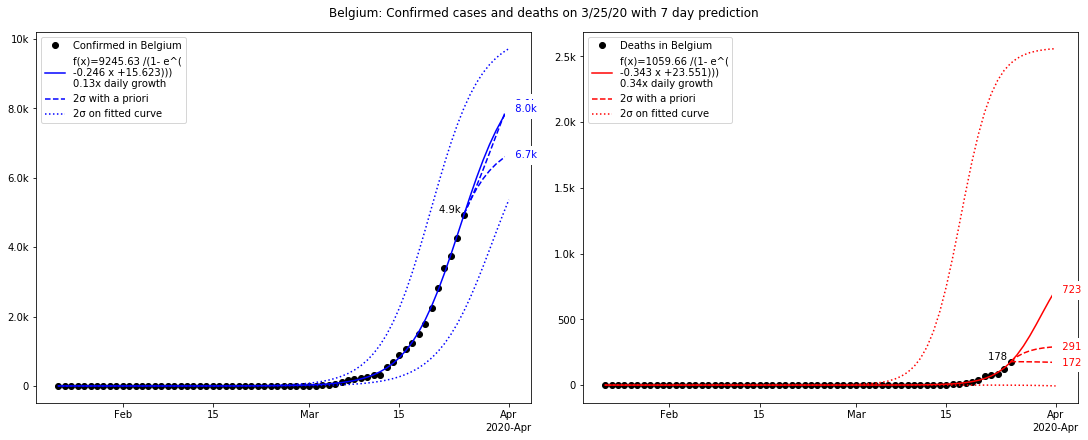

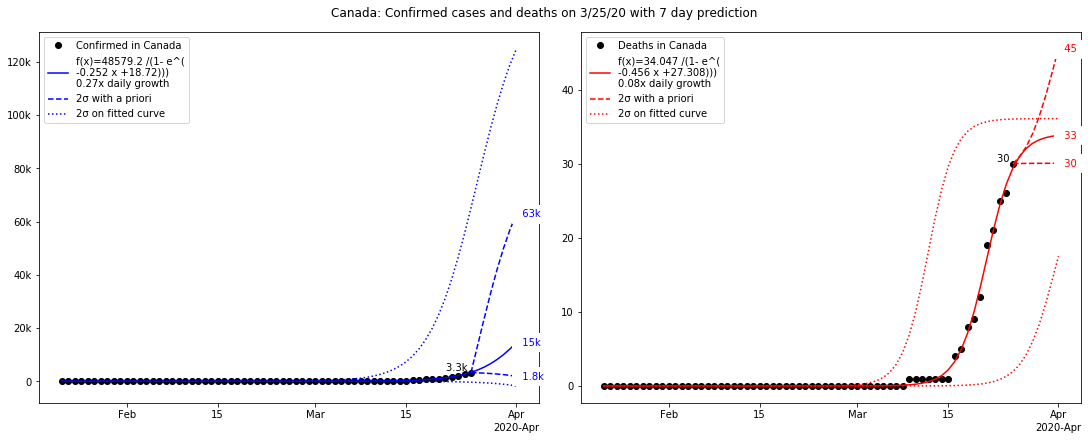

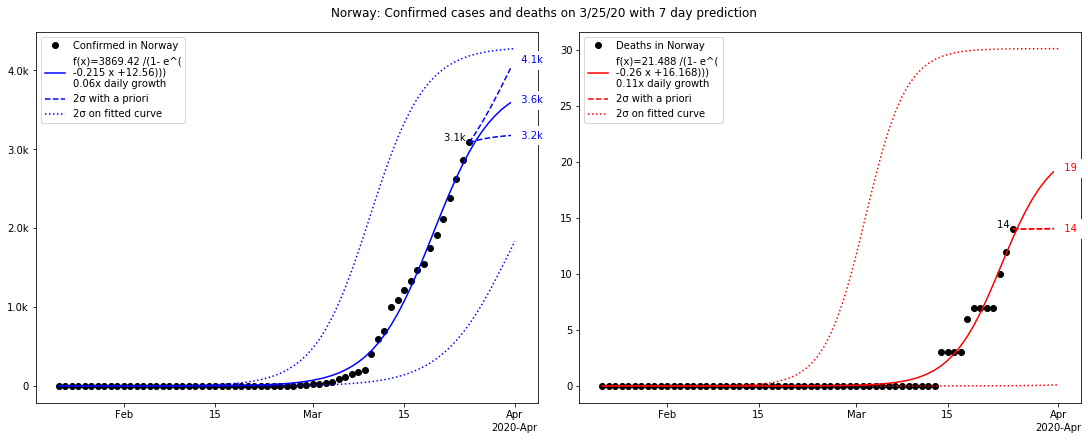

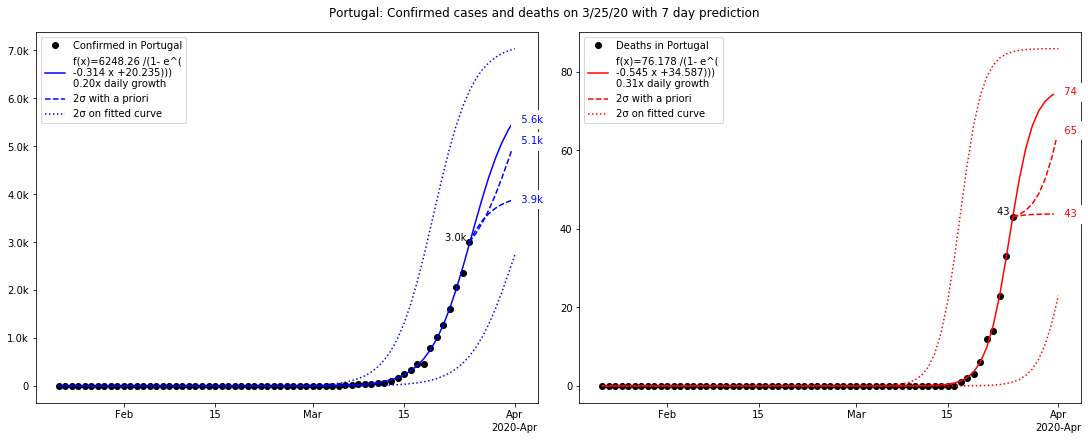

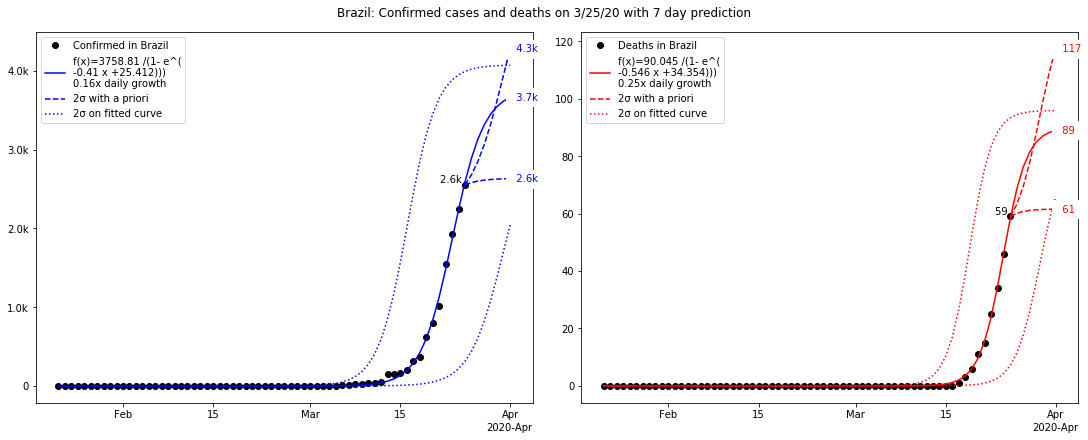

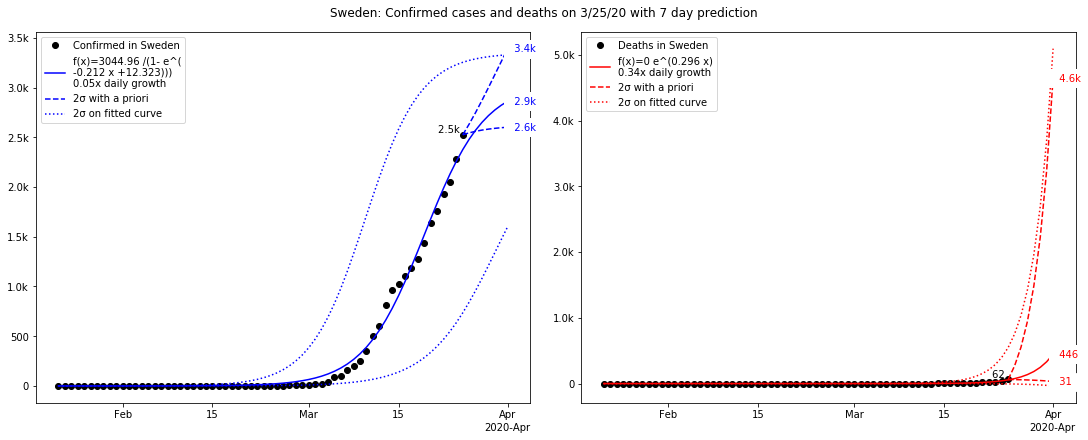

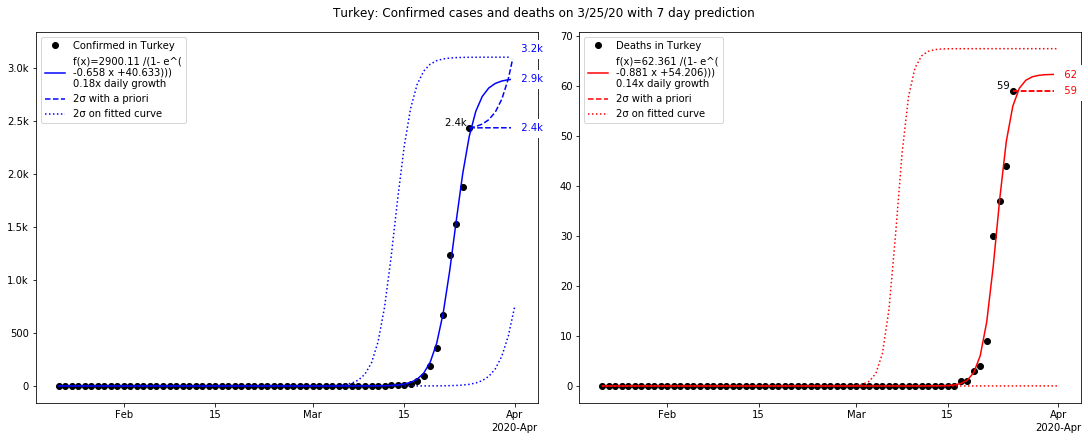

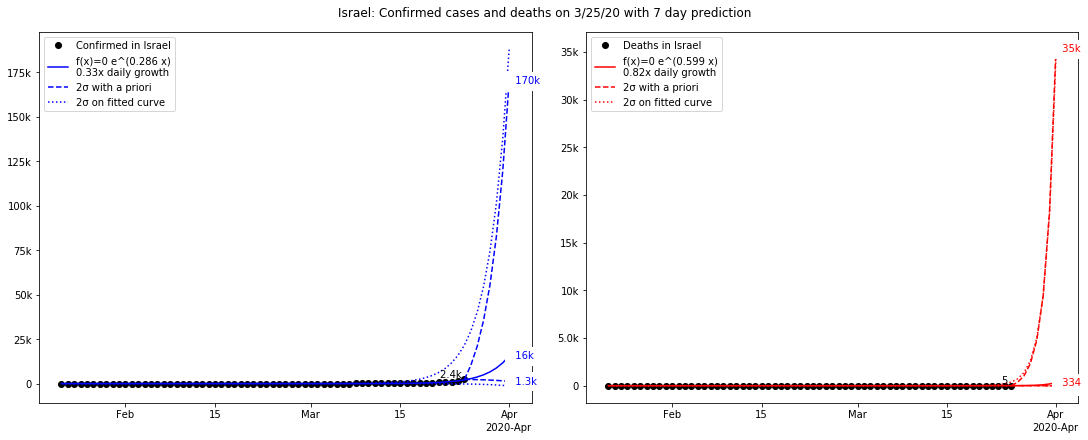

In [12]:
# Plot the raw data and the fitted curve on the given axes
def plotRawAndCurve(days, daynr, values, fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel, ax, label, name, fitDrawingStyle, extDayCount, yScale='linear'):
    # Plot raw data and label last data point 
    ax.set_yscale(yScale)
    ax.plot(days, values, 'ko', label="%s in %s" % (label, name))
    ax.text(days[-1], values[-1], "%s " % humanReadable(values[-1]), color='k', horizontalalignment="right", verticalalignment="bottom")

    # Plot the best fit projection, if it exists
    if fitSqdiff<sys.float_info.max:
        extDays, extDaynr=extendTime(days, np.array(daynr), extDayCount)
        
        # Plot projected scenario 
        extProj=fitFunc(extDaynr, *fitPopt)
        line, =ax.plot(extDays, extProj,  fitDrawingStyle, label=fitLabel)

        # Calculate two standard deviations for each parameter individually
        # For simplicity, we are taking the diagonal of the covariance matrix,
        # i.e. the variances of each parameter with itself. The square root
        # of that is one standard deviation. 
        pcov2Sigma=[2*np.sqrt(fitPcov[i][i]) for i in range(len(fitPopt))]

        # Plot low error bound via derivative
        poptLow=fitPopt.copy()-pcov2Sigma
        extProjLow=fitSigViaDerivative(extDaynr, values, fitFunc, poptLow)
        line, =ax.plot(extDays[len(values)-1:], extProjLow[len(values)-1:],  "%s-" % fitDrawingStyle, label="2\u03C3 with a priori")
        ax.text(extDays[-1], extProjLow[-1], "  %s" % humanReadable(extProjLow[-1]), color=line.get_color(), backgroundcolor='w', horizontalalignment="left", verticalalignment="center" )

        # Plot low error bound via projection
        extProjLowP=fitFunc(extDaynr, *poptLow)
        line, =ax.plot(extDays, extProjLowP,  "%s:" % fitDrawingStyle[:-1], label="2\u03C3 on fitted curve")
        
        # Plot high error bound via derivative
        poptHigh=fitPopt.copy()+pcov2Sigma
        extProjHigh=fitSigViaDerivative(extDaynr, values, fitFunc, poptHigh)
        line, =ax.plot(extDays[len(values)-1:], extProjHigh[len(values)-1:],  "%s-" % fitDrawingStyle, label=None)
        ax.text(extDays[-1], extProjHigh[-1], "  %s" % humanReadable(extProjHigh[-1]), color=line.get_color(), backgroundcolor='w', horizontalalignment="left", verticalalignment="center" )

        # Plot high error bound via projection
        extProjHighP=fitFunc(extDaynr, *poptHigh)
        line, =ax.plot(extDays, extProjHighP,  "%s:" % fitDrawingStyle[:-1], label=None)
        
        # Label projected scenario last, so it appears on top
        ax.text(extDays[-1], extProj[-1], "  %s" % humanReadable(extProj[-1]), color=line.get_color(), backgroundcolor='w', horizontalalignment="left", verticalalignment="center" )

    # Finish up the formatting
    locator = mdates.AutoDateLocator(minticks=5, maxticks=10)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(hrFormatter)
    ax.legend()
    
# Plot fits for the top K valid countries and given number of extension days
extDayCount=7
for i, cty in enumerate(validCountries[0:topK], start=0):
    # Retrieve data and fit
    name=cty['Name']
    
    # Prepare plot area
    plt.rcParams['figure.figsize'] = [15, 6]
    fig, axs=plt.subplots(nrows=1, ncols=2, constrained_layout=True)
    plt.suptitle('%s: Confirmed cases and deaths on %s with %d day prediction' % (name, today, extDayCount))
    #fig, axs=plt.subplots(nrows=1, ncols=3, constrained_layout=True)
    #plt.suptitle('%s: Confirmed cases, recovered and deaths on %s with %d day prediction' % (name, today, extDayCount))

    # Select and plot data for this country
    chartParams=[(confd, confdFits, axs[0], "Confirmed", "b-"), (deaths, deathsFits, axs[1], "Deaths", "r-")]
    #chartParams=[(confd, confdFits, axs[0], "Confirmed", "b-"), (recovd, recovdFits, axs[1], "Recovered", "g-"), (deaths, deathsFits, axs[2], "Deaths", "r-")]
    for df, fits, ax, legend, fitDrawingStyle in chartParams:
        days, daynr, values=getData(df, name)
        fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel=fits[name]
        plotRawAndCurve(days, daynr, values, fitFunc, fitPopt, fitPcov, fitSqdiff, fitLabel, ax, legend, name, fitDrawingStyle, extDayCount, yScale='linear')
    plt.show()

Return to [daily series overview](https://mlnoga.github.io/covid19-analysis/).

For questions and comments, please reach out to me on [LinkedIn](https://www.linkedin.com/in/mlnoga/) or [Twitter](https://twitter.com/mlnoga).